# PyPSA-VGR

## Input

## The network

This model is created at a level of aggregated production and consumption in VGR of each type of energy production, storage, and consumption.

The network contains:
- A main bus with
    - A static target load (representing the minimal target load desired, see Optimization below)
    - An onshore wind generator
    - An offshore wind generator
    - A solar generator
- A battery bus with
    - A store (battery)
    - Two links to and from the main bus with efficiencies <1 and a capital cost representing the inverter
- A hydrogen bus with
    - 
- A market bus with
    -


## Optimization

In [1]:
# Config and imports

import pypsa
import logging
import atlite
import time
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import plotly
from datetime import datetime
import matplotlib.pyplot as plt


logging.basicConfig(level=logging.INFO)

## Weather data window
START="2011-01"
END="2011-12"

## Västra götalands län
vgr_code = "14" 

## Single municipal
selected_kom_code = "1480" # Gbg

## Or all municipals
selected_kom_code = None

## Wind turbines
WIND_TURBINE = "Vestas_V25_200kW"
WIND_TURBINE = "Vestas_V47_660kW"
WIND_TURBINE = "Bonus_B1000_1000kW"
WIND_TURBINE = "Suzlon_S82_1.5_MW"
WIND_TURBINE = "Vestas_V66_1750kW"
WIND_TURBINE = "Vestas_V80_2MW_gridstreamer"
WIND_TURBINE = "Siemens_SWT_2300kW"
WIND_TURBINE = "Vestas_V90_3MW"
WIND_TURBINE_OFFSHORE = "Vestas_V90_3MW"

## Cost assumptions (get from technology-data instead)
eur_to_sek = 11.68 # 2024-05-15 12:50
assumptions = pd.read_csv("data/techdata/costs_2025.csv", index_col=list(range(2))).sort_index()
assumptions.loc[assumptions.unit.str.contains("/kW"),"value"]*=1e3
assumptions.loc[assumptions.unit.str.contains("EUR"),"value"]*=eur_to_sek

In [2]:
# Create main cutout for VGR/municipality

sweden = gpd.read_file("data/geo/georef-sweden-kommun@public.geojson") #Source Lantmäteriverket, data maintained by opendatasoft.com

vgr = sweden.loc[sweden.lan_code.apply(lambda x: vgr_code in x)]

minx, miny, maxx, maxy = vgr.total_bounds

cutout = atlite.Cutout(
    path=str(f"vgr-{selected_kom_code}-{START}-{END}.nc"),
    module="era5",
    x=slice(minx, maxx),
    y=slice(miny, maxy),
    time=slice(START,END),
    dx=0.125,
    dy=0.125,
    dt="3h"
)

start_time = time.time()

cutout.prepare(features=['influx', 'temperature', 'wind'])

print("Execution time: %.4f minutes" % ((time.time() - start_time) / 60))


if selected_kom_code is None:
    selection = gpd.GeoDataFrame(geometry=[unary_union(vgr.geometry)], crs=vgr.crs)
else:
    selection = vgr.loc[vgr['kom_code'].isin(selected_kom_code)]


# EEZ (Economical zone)
shapefile_path = "data/geo/Ekonomiska_zonens_yttre_avgränsningslinjer/Ekonomiska_zonens_yttre_avgränsningslinjer_linje.shp"
eez_shape = gpd.read_file(shapefile_path).to_crs(selection.crs)
min_x, min_y, max_x, max_y = eez_shape.total_bounds
# Arbitrarily using min/max from cutout or eez to visualize it on VGR region
bounding_box = Polygon([(min_x, miny), (min_x, maxy), (maxx, maxy), (maxx, miny)])
bounds = gpd.GeoDataFrame(geometry=[bounding_box], crs=selection.crs) 
eez = gpd.overlay(eez_shape, bounds, how='intersection')

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/cutout.py:190: UserWarning:

Arguments module, x, y, time, dx, dy, dt are ignored, since cutout is already built.

INFO:atlite.data:Cutout already prepared.


Execution time: 0.0002 minutes


In [3]:
# Exclude land use per solar/wind

import atlite
import xarray as xr
import matplotlib.pyplot as plt
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

# Source: https://www.uts.edu.au/oecm/renewable-resource-mapping
# (Classification mapping: https://collections.sentinel-hub.com/corine-land-cover/readme.html)
# With the exception of "41; Water bodies"

# Land-cover classes NOT included for solar areas:
EXCLUDED_SOLAR = [1,4,5,6,7,9,10,11,23,24,25,27,30,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
# Land-cover classes NOT included for wind energy areas:
EXCLUDED_WIND_NON_OCEAN = [1,2,3,4,5,6,7,9,10,11,15,16,17,23,24,25,27,30,31,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.1.2,1.2.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,2.2.1,2.2.2,2.2.3,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.2,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
INCLUDED_WIND_OCEAN = [44, 41] # 5.2.3, 5.1.2


CORINE = "data/geo/corine.tif"
solar_excluder = ExclusionContainer()
wind_onshore_excluder = ExclusionContainer()
wind_offshore_excluder = ExclusionContainer()

solar_excluder.add_raster(CORINE, codes=EXCLUDED_SOLAR)
wind_onshore_excluder.add_raster(CORINE, codes=EXCLUDED_WIND_NON_OCEAN)
wind_offshore_excluder.add_raster(CORINE, codes=INCLUDED_WIND_OCEAN, invert=True)

solar_avail = cutout.availabilitymatrix(selection, solar_excluder)
wind_onshore_avail = cutout.availabilitymatrix(selection, wind_onshore_excluder)
wind_offshore_avail = cutout.availabilitymatrix(selection, wind_offshore_excluder)

Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  6.81 gridcells/s]


In [4]:
# Atlite availability results : SOLAR

solar_availability_matrix = solar_avail.stack(spatial=["y", "x"])
mean_solar_capacity_factor = cutout.pv(
    matrix=solar_availability_matrix,
    panel=atlite.solarpanels.CdTe,
    orientation="latitude_optimal",
    index=selection.index,
    per_unit =True,
)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [5]:
# Atlite availability results : WIND ONSHORE

wind_onshore_availability_matrix = wind_onshore_avail.stack(spatial=["y", "x"])
mean_wind_onshore_capacity_factor = cutout.wind(
    matrix=wind_onshore_availability_matrix,
    turbine = f"{WIND_TURBINE}",
    index=selection.index,
    per_unit =True,
)

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.

INFO:atlite.convert:Convert and aggregate 'wind'.


In [6]:
# Atlite availability results : WIND OFFSHORE

wind_offshore_availability_matrix = wind_offshore_avail.stack(spatial=["y", "x"])
mean_wind_offshore_capacity_factor = cutout.wind(
    matrix=wind_offshore_availability_matrix,
    turbine = f"{WIND_TURBINE_OFFSHORE}",
    index=selection.index,
    per_unit =True,
)

/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/atlite/resource.py:72: FutureWarning:

'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.

INFO:atlite.convert:Convert and aggregate 'wind'.


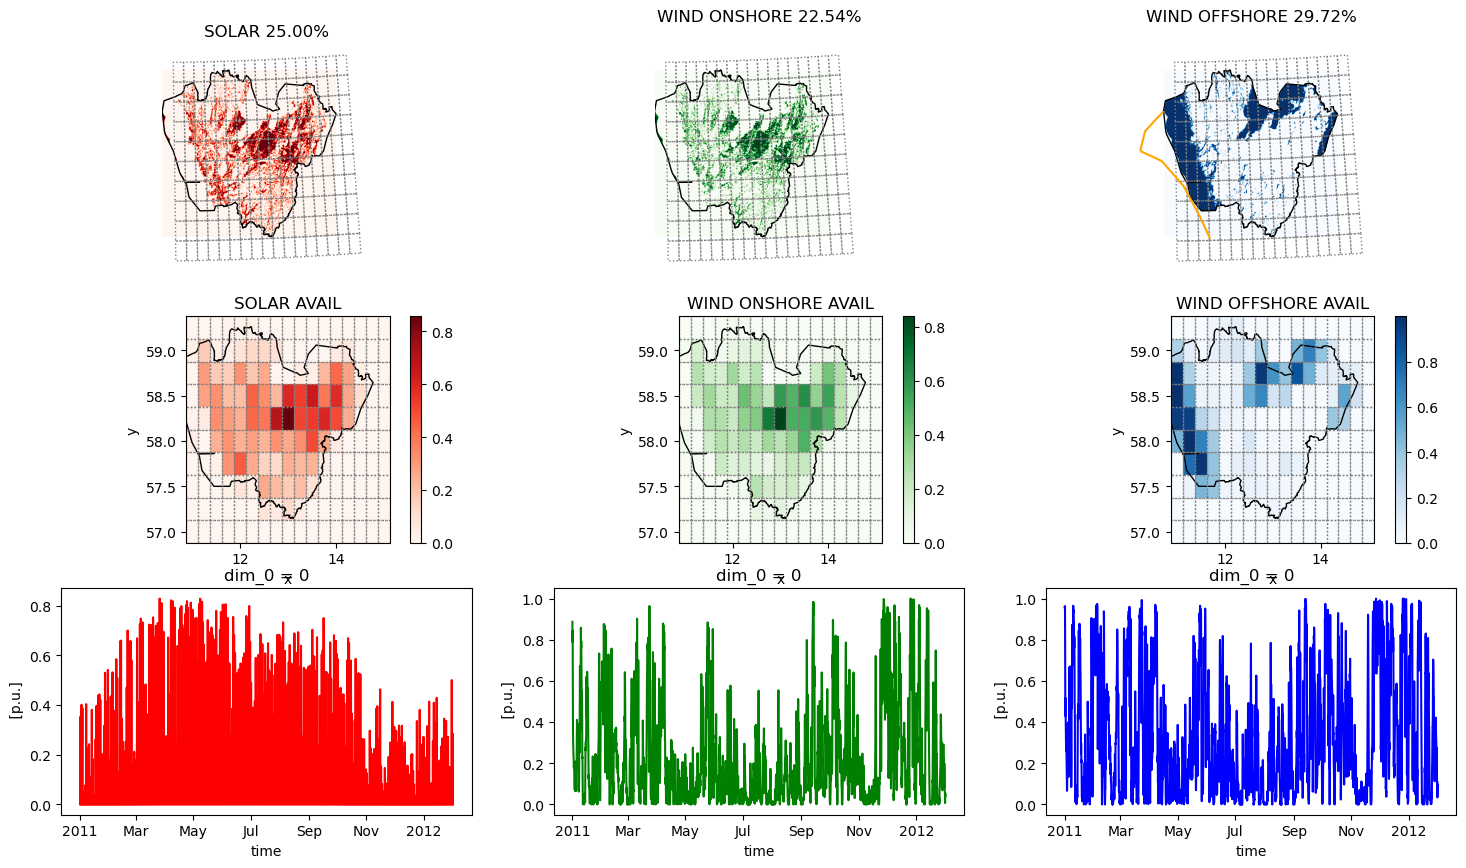

In [9]:
# Some graphs

from matplotlib.gridspec import GridSpec

crs = selection.geometry.to_crs(solar_excluder.crs)
masked, transform = solar_excluder.compute_shape_availability(crs)
solar_eligible_share = masked.sum() * solar_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_onshore_excluder.crs)
masked, transform = wind_onshore_excluder.compute_shape_availability(crs)
wind_onshore_eligible_share = masked.sum() * wind_onshore_excluder.res**2 / crs.geometry.item().area

crs = selection.geometry.to_crs(wind_offshore_excluder.crs)
masked, transform = wind_offshore_excluder.compute_shape_availability(crs)
wind_offshore_eligible_share = masked.sum() * wind_offshore_excluder.res**2 / crs.geometry.item().area

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

# Solar
solar_excluder.plot_shape_availability(selection, ax=ax1, show_kwargs = { "cmap": "Reds" })
cutout.grid.to_crs(solar_excluder.crs).plot(edgecolor="grey", color="None", ax=ax1, ls=":")
ax1.set_title(f"SOLAR {solar_eligible_share:.2%}")
ax1.axis("off");

# Wind (onshore)
wind_onshore_excluder.plot_shape_availability(selection, ax=ax2, show_kwargs = { "cmap": "Greens" })
cutout.grid.to_crs(wind_onshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax2, ls=":")
ax2.set_title(f"WIND ONSHORE {wind_onshore_eligible_share:.2%}")
ax2.axis("off");

# Wind (offshore)
wind_offshore_excluder.plot_shape_availability(selection, ax=ax3, show_kwargs = { "cmap": "Blues" })
cutout.grid.to_crs(wind_offshore_excluder.crs).plot(edgecolor="grey", color="None", ax=ax3, ls=":")
eez.to_crs(wind_offshore_excluder.crs).plot(color="Orange", ax=ax3)
ax3.set_title(f"WIND OFFSHORE {wind_offshore_eligible_share:.2%}")
ax3.axis("off");

# Solar avail
solar_avail.sel(dim_0=0).plot(cmap="Reds", ax=ax4)
selection.plot(ax=ax4, edgecolor="k", color="None")
cutout.grid.plot(ax=ax4, color="None", edgecolor="grey", ls=":")
ax4.set_title("SOLAR AVAIL")

# Wind (onshore) avail
wind_onshore_avail.sel(dim_0=0).plot(cmap="Greens", ax=ax5)
selection.plot(ax=ax5, edgecolor="k", color="None")
cutout.grid.plot(ax=ax5, color="None", edgecolor="grey", ls=":")
ax5.set_title("WIND ONSHORE AVAIL")

# Wind (offshore) avail
wind_offshore_avail.sel(dim_0=0).plot(cmap="Blues", ax=ax6)
selection.plot(ax=ax6, edgecolor="k", color="None")
cutout.grid.plot(ax=ax6, color="None", edgecolor="grey", ls=":")
ax6.set_title("WIND OFFSHORE AVAIL")

# Capacity factors
mean_solar_capacity_factor.plot(color="Red", ax=ax7)
mean_wind_onshore_capacity_factor.plot(color="Green", ax=ax8)
mean_wind_offshore_capacity_factor.plot(color="Blue", ax=ax9)

Max load: 110.09875315895317 MW


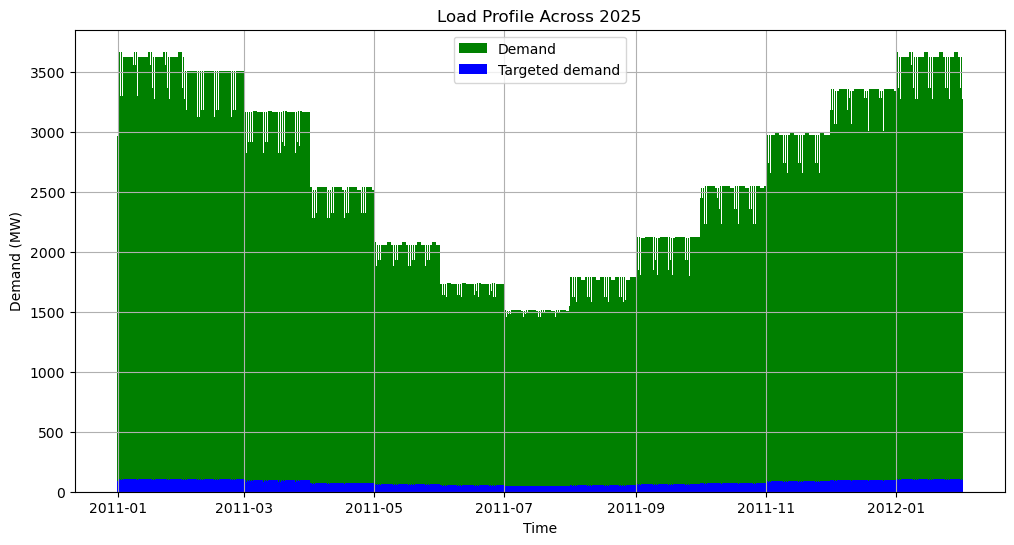

In [8]:
# Calculate and visualize demand (source: 2025 from behovskartan.se)

import matplotlib.pyplot as plt

## Create the timeseries index
index = pd.to_datetime(cutout.coords['time'])

## Load the demand data (it comes in a format of peak demand per each hour and per month and per weekend/weekday and per h3 hexagon)
demand_data = pd.read_csv('data/demand/demand_vgr_2025.csv')
demand_year = demand_data['Year'][0]
demand_data.drop(columns=['Unnamed: 0', 'Year'], inplace=True)
demand_data['Timestamp'] = pd.to_datetime(demand_data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
demand_data.set_index('Timestamp', inplace=True)

## Aggregate by summing over all the hexagons and resampling from 1h to 3h intervals
grouped_demand_data = demand_data.groupby([demand_data.index, 'Daytype']).sum()['Demand (MW)'].groupby([pd.Grouper(freq='3h', level=0), 'Daytype']).mean()

## Function that returns the appropriate demand for a given day
def select_demand(index):
    return grouped_demand_data[index.replace(year=demand_year ,day=1),'weekday' if index.weekday() < 5 else 'weekend']

## Build a load profile
target_percentage = 0.03 # This is the percentage (30%) of the demand that we want to fulfill
total_demand = [select_demand(i) for i in index]
target_load = [target_percentage*p for p in total_demand]
print("Max load: " + str(max(target_load)) + " MW")

plt.figure(figsize=(12, 6))  # Sets the figure size
plt.bar(index, total_demand, label='Demand', color='green')  # Plots the load profile against the index
plt.bar(index, target_load, label='Targeted demand', color='blue')  # Plots the load profile against the index
plt.title('Load Profile Across 2025')  # Sets the title of the graph
plt.xlabel('Time')  # Sets the label for the x-axis
plt.ylabel('Demand (MW)')  # Sets the label for the y-axis
plt.grid(True)  # Enables the grid for better readability
plt.legend()  # Adds a legend
plt.show()  # Displays the plot

In [10]:
# Set static load (TODO: replace with a more advanced load)

## Create the timeseries index
index = pd.to_datetime(cutout.coords['time'])

target_load = 10


/home/viktor/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x7f0437f8de90>,
 <matplotlib.collections.LineCollection at 0x7f0437f5b550>)

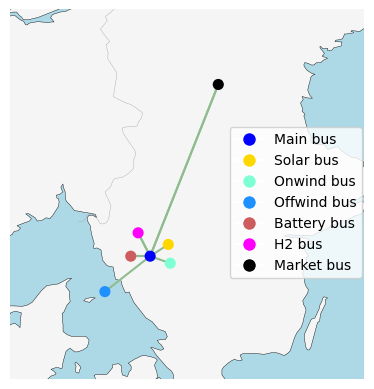

In [23]:
# Build and visualize the network

"""
The network:

A central bus that connects a solar generator, an onshore and an offshore wind generator, a battery, and a load.

"""

## Initialize the network
network = pypsa.Network()
network.set_snapshots(index)

## Carriers
carriers = [
    "onwind",
    "offwind",
    "solar",
    "li-ion",
    "h2",
    "market",
    ]

carrier_colors = ["blue", "gold", "aquamarine", "dodgerblue", "indianred", "black"]

network.madd(
    "Carrier",
    carriers,
    color=carrier_colors,
    )

## Main bus location
midx = (minx + maxx)/2
midy = (miny + maxy)/2

## Add the buses
network.add("Bus", "Main bus", x=midx, y=midy)
network.add("Bus", "Solar bus", x=midx+0.5, y=midy+0.25)
network.add("Bus", "Onwind bus", x=midx+0.5, y=midy-0.15)
network.add("Bus", "Offwind bus", x=midx-1.25, y=midy-0.75)
network.add("Bus", "Battery bus", x=midx-0.5, y=midy)
network.add("Bus", "H2 bus", x=midx-0.25, y=midy+0.5)
network.add("Bus", "Market bus", x=15, y=62)

## Add loads
network.add("Load", "Desired load", bus="Main bus",
            p_set=target_load
            )

## Add generators

### Solar
network.add("Generator", "Solar park", carrier="solar", bus="Solar bus",
            p_nom_extendable=True, 
            p_max_pu=mean_solar_capacity_factor.values.flatten(),
            capital_cost=assumptions.loc['solar-utility','investment'].value,
            )

network.add("Link", "Solar link",
            bus0="Solar bus",
            bus1="Main bus",
            p_nom_extendable=True,
            )

### Onwind
network.add("Generator", "Wind farm onshore", carrier="onwind", bus="Onwind bus",
            p_nom_extendable=True,
            p_max_pu=mean_wind_onshore_capacity_factor.values.flatten(),
            capital_cost=assumptions.loc['onwind','investment'].value,
            )

network.add("Link", "Onwind link",
            bus0="Onwind bus",
            bus1="Main bus",
            p_nom_extendable=True,
            )

### Offwind (TODO: add running cost, add downtime, )
network.add("Generator", "Wind farm offshore", carrier="offwind", bus="Offwind bus",
            p_nom_extendable=True, 
            p_max_pu=mean_wind_offshore_capacity_factor.values.flatten(),
            capital_cost=assumptions.loc['offwind','investment'].value,
            )

network.add("Link", "Offwind link",
            bus0="Offwind bus",
            bus1="Main bus",
            p_nom_extendable=True,
            )


## Add battery storage TODO: add running cost, 
network.add("Store", "Battery", carrier="li-ion", bus="Battery bus",
            e_nom_extendable=True,
            e_cyclic=True,
            capital_cost=assumptions.loc["battery storage", "investment"].value,
            )

network.add("Link","Battery charge",
            bus0 = "Main bus",
            bus1 = "Battery bus",
            efficiency = assumptions.loc['battery inverter','efficiency'].value,
            p_nom_extendable = True,
            capital_cost=assumptions.loc['battery inverter','investment'].value,
            )

network.add("Link","Battery discharge",
            bus0 = "Battery bus",
            bus1 = "Main bus",
            efficiency = assumptions.loc['battery inverter','efficiency'].value,
            p_nom_extendable = True,
            )

## Add H2 generation, storage, consumption, and sales
network.add("Link",
            "H2 electrolysis",
            bus0="Main bus",
            bus1="H2 bus",
            p_nom_extendable=True,
            efficiency=assumptions.loc["electrolysis","efficiency"].value,
            capital_cost=assumptions.loc["electrolysis","investment"].value
            )

network.add("Link",
            "H2 to power",
            bus0="H2 bus",
            bus1="Main bus",
            p_nom_extendable=True,
            efficiency=assumptions.loc["CCGT","efficiency"].value,
            capital_cost=assumptions.loc["CCGT","investment"].value*assumptions.loc["CCGT","efficiency"].value
            )

network.add("Store", "H2 storage", carrier="H2", bus="H2 bus",
            e_nom_extendable=True,
            e_cyclic=True,
            capital_cost=assumptions.loc["hydrogen storage tank type 1 including compressor","investment"].value
            )

## Add market (incl. existing production)
network.add("Load", "Market consumption", bus="Market bus",
            p_set=15000
            )

network.add("Generator", "Market production", carrier="market", bus="Market bus",
            p_nom=15000
            )

network.add("Link","Sell to market",
                bus0 = "Main bus",
                bus1 = "Market bus",
                p_nom_extendable = True,
                marginal_cost=-3000
                )

network.add("Link","Buy from market",
                bus0 = "Market bus",
                bus1 = "Main bus",
                p_nom_extendable = True,
                marginal_cost=3000+300
                )

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.EqualEarth()})
bus_colors = ["blue", "gold", "aquamarine", "dodgerblue", "indianred", "magenta", "black"]


# Create a custom legend for the bus names
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=bus, 
                            markerfacecolor=color, markersize=10) for bus, color in zip(network.buses.index, bus_colors)]

# Add the legend to the plot
ax.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.6, 0.7), ncol=1)


network.plot(ax=ax, boundaries = [minx-1, maxx+3, miny-1.5, maxy+4.5], color_geomap=True, bus_sizes=0.02, bus_colors=bus_colors)


In [24]:
# Run the optimization

## Define the objective function (minimize cost)
network.optimize()

network.model

INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 96.64it/s]
INFO:linopy.io: Writing time: 0.71s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-ondpd60w.lp --output /tmp/linopy-solve-cctr6o8_.sol
Reading problem data from '/tmp/linopy-problem-ondpd60w.lp'...
123566 rows, 53870 columns, 232673 non-zeros
663585 lines were read
GLPK Simplex Optimizer 5.0
123566 rows, 53870 columns, 232673 non-zeros
Preprocessing...
67545 rows, 47156 columns, 168165 non-zeros
Scaling...
 A: min|aij| =  2.268e-07  max|aij| =  1.000e+00  ratio =  4.409e+06
GM: min|aij| =  2.159e-01  max|aij| =  4.632e+00  ratio =  2.146e+01
EQ: min|aij| =  4.812e-02  max|aij| =  1.000e+00  ratio =  2.078e+01
Constructing initial basis...
Size of triangular part is 67543
      0: obj =   1.045440000e+08 inf =   4.831e+04 (6336)
   3349: obj =   2.6760091

Linopy LP model

Variables:
----------
 * Generator-p_nom (Generator-ext)
 * Link-p_nom (Link-ext)
 * Store-e_nom (Store-ext)
 * Generator-p (snapshot, Generator)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * Store-p (snapshot, Store)

Constraints:
------------
 * Generator-ext-p_nom-lower (Generator-ext)
 * Generator-ext-p_nom-upper (Generator-ext)
 * Link-ext-p_nom-lower (Link-ext)
 * Link-ext-p_nom-upper (Link-ext)
 * Store-ext-e_nom-lower (Store-ext)
 * Store-ext-e_nom-upper (Store-ext)
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Generator-ext-p-lower (snapshot, Generator-ext)
 * Generator-ext-p-upper (snapshot, Generator-ext)
 * Link-ext-p-lower (snapshot, Link-ext)
 * Link-ext-p-upper (snapshot, Link-ext)
 * Store-ext-e-lower (snapshot, Store-ext)
 * Store-ext-e-upper (snapshot, Store-ext)
 * Bus-nodal_balance (Bus, snapshot)
 * Store-energy_balance (snapshot, Store)

Status:
-------
ok

In [25]:
network.statistics()

Optimal Capacity  Installed Capacity  \
Generator market               15000.000000             15000.0   
          offwind                 23.472700                 0.0   
          onwind                   0.000000                 0.0   
          solar                  186.409000                 0.0   
Link      AC                     378.297632                 0.0   
Load      -                        0.000000                 0.0   
Store     H2                     122.233000                 0.0   
          battery storage        141.222000                 0.0   

                           Capacity Factor      Dispatch   Transmission  \
Generator market                  0.998660  4.745634e+07       0.000000   
          offwind                 0.333152  2.477368e+04       0.000000   
          onwind                       NaN  0.000000e+00       0.000000   
          solar                   0.120819  7.134895e+04       0.000000   
Link      AC                      0.145750 -7.845788e+02  174674.029504   
Load      -                            NaN -4.755168e+07       0.000000   
Store     H2                      0.490232 -5.740000e-05       0.000000   
          battery storage         0.545291 -1.499470e-03       0.000000   

                             Withdrawal        Supply  Curtailment  \
Generator market           0.000000e+00  4.745634e+07     0.000000   
          offwind          0.000000e+00  2.477368e+04     0.004656   
          onwind           0.000000e+00  0.000000e+00     0.000000   
          solar            0.000000e+00  7.134895e+04     0.025314   
Link      AC               1.746740e+05  1.738895e+05     0.000000   
Load      -                4.755168e+07  0.000000e+00     0.000000   
Store     H2               1.861787e+02  1.861786e+02     0.000000   
          battery storage  7.048272e+03  7.048270e+03     0.000000   

                           Capital Expenditure  Operational Expenditure  \
Generator market                  0.000000e+00             0.000000e+00   
          offwind                 5.939790e+08             0.000000e+00   
          onwind                  0.000000e+00             0.000000e+00   
          solar                   1.023165e+09             0.000000e+00   
Link      AC                      1.268814e+08            -1.909742e+08   
Load      -                       0.000000e+00             0.000000e+00   
Store     H2                      8.309206e+07             0.000000e+00   
          battery storage         3.035420e+08             0.000000e+00   

                                Revenue   Market Value  
Generator market           2.762231e+12   58205.723167  
          offwind          5.939801e+08   23976.257339  
          onwind           0.000000e+00       0.000000  
          solar            1.023166e+09   14340.303798  
Link      AC              -6.409212e+07    -368.579684  
Load      -               -2.764170e+12            NaN  
Store     H2               8.309162e+07  446300.621545  
          battery storage  3.035413e+08   43066.064809

In [26]:
network.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Solar park,Solar bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,186.4090
Wind farm onshore,Onwind bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0000
Wind farm offshore,Offwind bus,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,23.4727
Market production,Market bus,PQ,,15000.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,15000.0000
